
# **Ayudantía 11: Aprendizaje supervisado (REGRESIONES)**


## Introducción

El **aprendizaje supervisado** es una de las ramas fundamentales del *Machine Learning*.  
Su objetivo principal es **entrenar un modelo que aprenda una relación entre un conjunto de variables de entrada (X)** y una **variable de salida (y)**, utilizando ejemplos conocidos.

En este enfoque, el modelo "aprende" a partir de un **conjunto de datos etiquetados**, donde cada observación tiene un valor conocido de la variable objetivo.  
Luego, ese conocimiento se usa para **predecir** o **estimar** la salida de nuevos datos no vistos.

---

### Estructura general del proceso

1. **Datos de entrada (X):** variables o características que describen los ejemplos (por ejemplo, peso, potencia, cilindros de un vehículo).  
2. **Etiqueta (y):** el valor que queremos predecir (por ejemplo, consumo `mpg`).  
3. **Entrenamiento:** el algoritmo ajusta los parámetros del modelo para minimizar el error entre las predicciones y los valores reales.  
4. **Evaluación:** se mide el rendimiento del modelo con datos de prueba (`test`) para estimar su capacidad de generalización.

---

### Tipos de aprendizaje supervisado

- **Regresión:** la variable objetivo (`y`) es **continua**.  
  Ejemplo: predecir el consumo de combustible según las características del coche.
  
- **Clasificación:** la variable objetivo (`y`) es **categórica**.  
  Ejemplo: clasificar correos como *spam* o *no spam*.

---

### Objetivos de esta ayudantía

En esta ayudantía trabajaremos con **regresión supervisada**, aplicando diferentes modelos:
- Regresión **lineal simple**
- Regresión **lineal multivariable**
- Regresión **polinomial**
- Modelos con **regularización** (Ridge y Lasso)

El propósito es entender **cómo aprende un modelo** a partir de los datos, **cómo evaluar su desempeño**, y **cómo elegir la complejidad adecuada** para evitar el sobreajuste (*overfitting*).


### Dataset

Introducción
AutoMPG8 Es un dataset usado en problemas regresión. En los que el objetivo está en predecir MPG, galones por milla, consumidos por los coches en función de ciertos parámetros. Como su velocidad, peso, aceleración…

Antes de comenzar a analizar los datos, debemos buscar informacion relativa a estos y su contexto para ubicar el problema en sí.

- **Cylinders:** Número de cilindros del coche.  
- **Displacement:** Medida de longitud (no se ha identificado exactamente a qué corresponde ni en qué unidad está).  
- **Horse_power:** Caballos de potencia del vehículo.  
- **Weight:** Peso del coche.  
- **Acceleration:** Aceleración del coche.  
- **Model_year:** Año de fabricación del coche.  
- **Origin:** Origen o región de procedencia del coche.  
- **Mpg:** *Miles Per Gallon* (millas por galón). Es el consumo del coche y la **variable dependiente** en nuestro problema.  
  - Valores **más pequeños** indican **mayor consumo** (se recorren menos millas por galón).  
  - Será la variable que **predeciremos mediante regresión**.


Ahora que conocemos algo más del contexto del dataset al que nos enfrentamos, trataremos de focalizarnos en los datos técnicos y del dominio del mismo.

## Estas son algunas de hartas métricas que pueden usar para evaluar que tan bien funciona su modelo de ML

- 1. **Mean Absolute Value**: Es el promedio de las diferencias en valor absoluto entre las predicciones y los valores reales.

$$MAE = \frac{1}{n} \sum_{i=1}^{n} |(y_i - \hat{y}_i)|$$

**En este contexto esperamos que sea un valor bajo. Mientras mas bajo sea, significa que mejor se ajusta el modelo (Si es 0 es un ajuste perfecto)**

- 2. **root mean squared error**: Es la raiz cuadrada del error cuadrático medio.

$$RMSE =\sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)}$$

**En este contexto esperamos también un valor bajo. La virtud de este error es que penaliza los errores grandes, por lo que si el valor de este fuese mayor que el MAE, signfiica que hay outliers o errores muy grandes**

-3. $R^2$ Score: Mide la proporción de varianza en los datos de salida que el modelo es capaz de explicar. Indica qué tan bien las predicciones replican los resultados reales.

$$ R^2 = \frac{(y_i - \hat{y}_i)^2}{(y_i - \overline{y})^2}$$

**Un valor cercano a 1 indica que indica que la regresión lineal está bien ajustada, es decir, que el modelo explica bien la variabilidad de los datos**



## 1) Carga y limpieza mínima


In [2]:

import pandas as pd, numpy as np
df = pd.read_csv("auto-mpg.csv")
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")
cols = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model year","origin"]
dfc = df[cols].dropna().copy()
print("Shape limpio:", dfc.shape)
dfc.head(3)


Shape limpio: (392, 8)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1



## 2) Split Train/Test + Baseline


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
RANDOM_STATE = 42
train, test = train_test_split(dfc, test_size=0.2, random_state=RANDOM_STATE)

y_train = np.array(train.mpg)
y_test = np.array(test.mpg)

y_base = np.full_like(y_test, y_train.mean(), dtype=float)
baseline = {"MSE": mean_squared_error(y_test, y_base),
            "MAE": mean_absolute_error(y_test, y_base),
            "R2": r2_score(y_test, y_base)}
baseline


{'MSE': 51.62029239680701,
 'MAE': 5.880956039956324,
 'R2': -0.011357808240890499}

### ¿Para qué sirven las métricas del baseline?

El baseline es un modelo “nulo” que siempre predice un valor simple (aquí, la media de y_train). Calcular sus métricas sirve para:

- Establecer un punto de referencia mínimo: cualquier modelo útil debe mejorar estas métricas.
- Chequeo de cordura: si un modelo complejo no supera al baseline, probablemente hay poco señal en las variables, mala configuración o problemas en los datos.
- Contextualizar la ganancia: permite cuantificar cuánto mejora el MAE/RMSE y el R² respecto a “no modelar”.
- Comparar modelos e hiperparámetros: evita elegir un modelo que solo parece bueno en términos absolutos pero no aporta sobre el trivial.
- Interpretación del R²: con un predictor constante,
    - usando la media de test, R² ≈ 0;
    - usando la media de train (como aquí), R² puede ser levemente negativo por desplazamientos entre conjuntos.

En resumen, el baseline fija el nivel que un modelo debe superar para considerarse que agrega valor predictivo.


## 3) Lineal **simple** (1 variable)
Elegimos el predictor con mayor |correlación| con `mpg`.

In [4]:

num_feats = ["cylinders","displacement","horsepower","weight","acceleration","model year","origin"]
corrs = train[num_feats + ["mpg"]].corr(numeric_only=True)["mpg"].drop("mpg").abs().sort_values(ascending=False)
best_feat = corrs.index[0]
corrs, best_feat


(weight          0.835568
 displacement    0.811580
 horsepower      0.782381
 cylinders       0.780555
 model year      0.590454
 origin          0.569064
 acceleration    0.412048
 Name: mpg, dtype: float64,
 'weight')

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
mpg,1.00,-0.78,-0.81,-0.78,-0.83,0.42,0.58,0.57
cylinders,-0.78,1.00,0.95,0.84,0.90,-0.50,-0.35,-0.57
displacement,-0.81,0.95,1.00,0.90,0.93,-0.54,-0.37,-0.61
horsepower,-0.78,0.84,0.90,1.00,0.86,-0.69,-0.42,-0.46
weight,-0.83,0.90,0.93,0.86,1.00,-0.42,-0.31,-0.59
acceleration,0.42,-0.50,-0.54,-0.69,-0.42,1.00,0.29,0.21
model year,0.58,-0.35,-0.37,-0.42,-0.31,0.29,1.00,0.18
origin,0.57,-0.57,-0.61,-0.46,-0.59,0.21,0.18,1.00


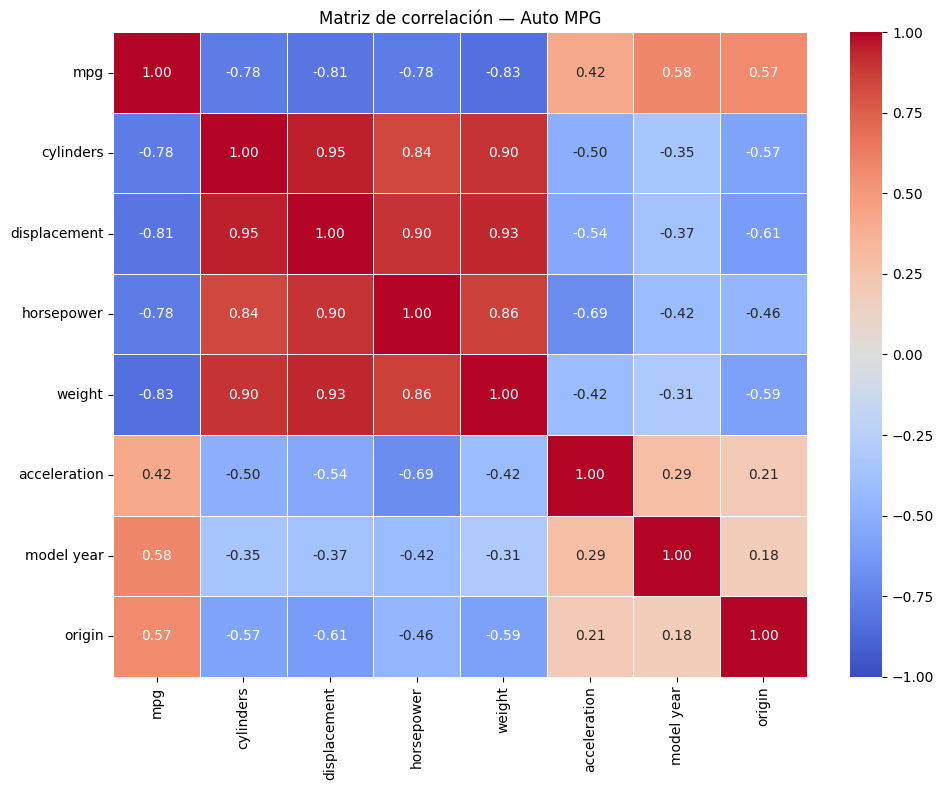

In [5]:
# Heatmap de correlación (variables numéricas de dfc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr = dfc.corr(numeric_only=True).round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación — Auto MPG')
plt.tight_layout()

corr

Text(0, 0.5, 'MPG')

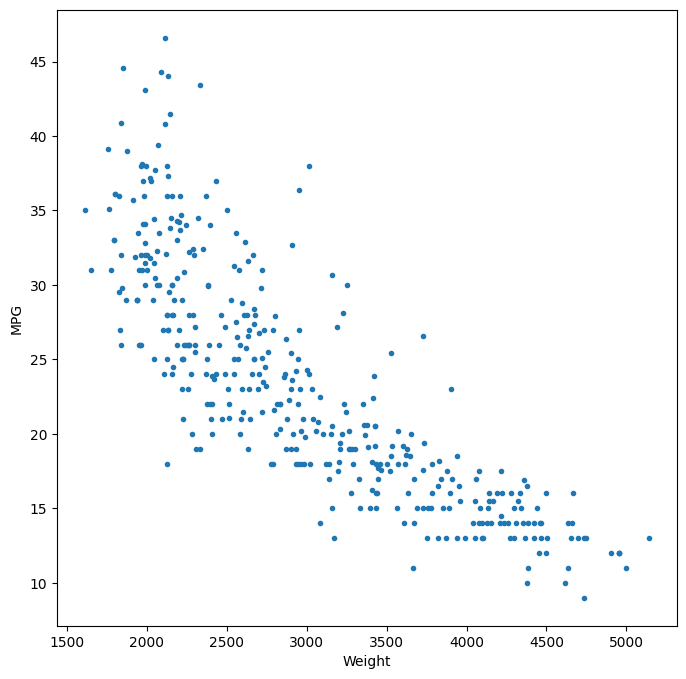

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(df['weight'], df['mpg'], '.')
ax.set_xlabel('Weight')
ax.set_ylabel('MPG')

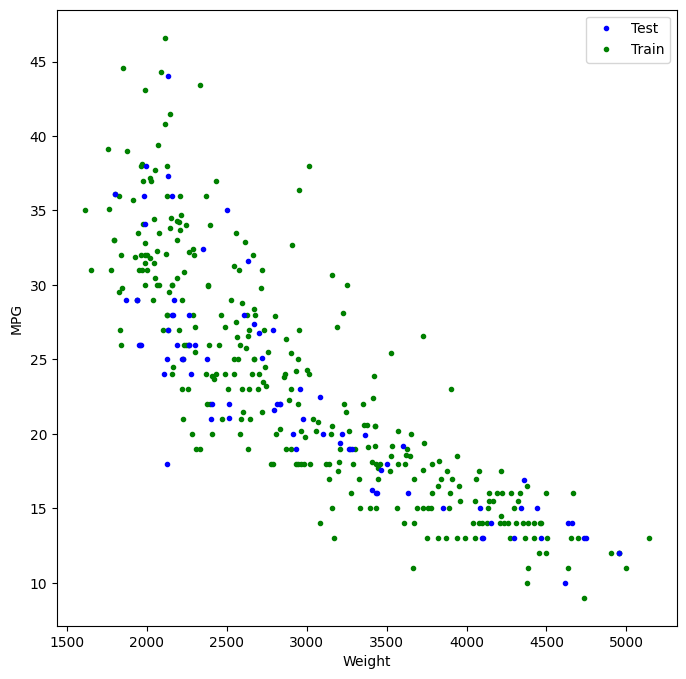

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(test['weight'], test['mpg'], ".", color='b', zorder=1, label='Test') # zorder para que los puntos de test queden encima
plt.plot(train['weight'], train['mpg'], ".", color='g', zorder=0, label='Train') # zorder para que los puntos de train queden debajo

ax.set_xlabel('Weight')
ax.set_ylabel('MPG')
ax.legend()

In [ ]:
from sklearn.linear_model import LinearRegression

# haremos los modelos usando la librearía sklearn en este caso.
# los inputs deben ser arreglos de numpy (en el caso del vector y podría ser Series, que es un arreglo de numpy + etiqueta)
y_train = np.array(train.mpg)
y_test = np.array(test.mpg)

#sklearn requiere que X sea una matrix de (n_samples x n_variables)
X_train = np.array(train.weight)
X_train = X_train.reshape(X_train.shape[0], 1) # reshape para que sea una matriz (n_samples x 1)

X_test = np.array(test.weight)
X_test = X_test.reshape(X_test.shape[0], 1) # reshape para que sea una matriz (n_samples x 1)

lin = LinearRegression().fit(X_train, y_train) # Fit para que aprenda los coeficientes
y_pred_train = lin.predict(X_test) # predecimos en test
metrics_lin_simple = {"MSE": mean_squared_error(y_test, y_pred_train),
                      "MAE": mean_absolute_error(y_test, y_pred_train),
                      "R2": r2_score(y_test, y_pred_train)}
metrics_lin_simple

{'MSE': 17.693388269545686,
 'MAE': 3.4641211922147592,
 'R2': 0.6533466675646016}

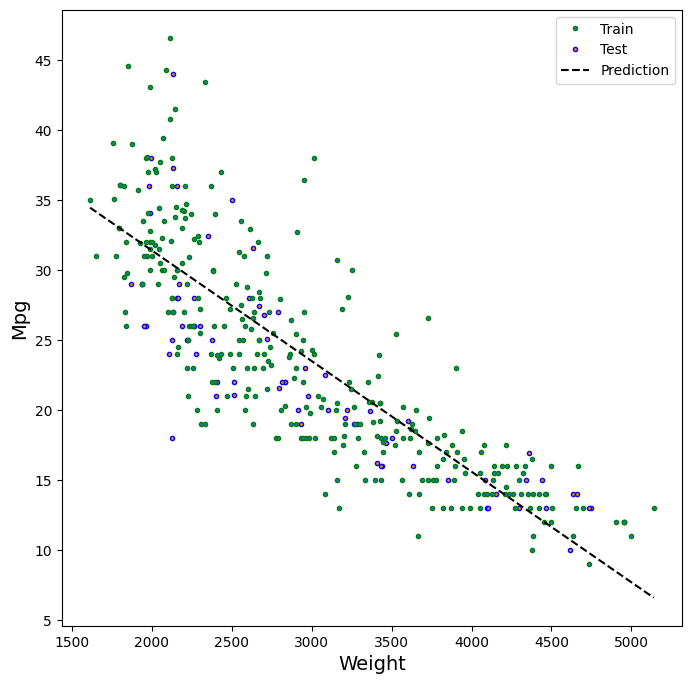

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.plot(train.weight, train.mpg, '.', zorder=1, mec='green', label='Train') 
ax.plot(test.weight, test.mpg, '.', zorder=0, mec='blue', label='Test') 

xgrid = np.linspace(np.min(train.weight), np.max(train.weight), 100)
ax.plot(xgrid, lin.predict(xgrid.reshape(100, 1)),label='Prediction',color='k',ls='--')
ax.set_xlabel('Weight',fontsize=14)
ax.set_ylabel('Mpg',fontsize=14)
ax.legend()


## 5) **Polinomial** (grado 2, 1 variable)


In [10]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2, include_bias=False) #Haremos un ajuste polinomial de grado 2.

poly_x_train = poly.fit_transform(X_train) # Transformamos X_train a sus características polinomiales
poly_x_test = poly.fit_transform(X_test) # Transformamos X_test a sus características polinomiales

plr = LinearRegression()

plr.fit(poly_x_train, y_train)

y_pred_poly = plr.predict(poly_x_test)
metrics_poly = {"MSE": mean_squared_error(y_test, y_pred_poly),
                "MAE": mean_absolute_error(y_test, y_pred_poly),
                "R2": r2_score(y_test, y_pred_poly)}
metrics_poly


{'MSE': 16.689074196004473, 'MAE': 3.13832628290579, 'R2': 0.6730234425893193}

Es decir, el modelo ahora aprenderá:

$$
\hat{y} = \beta_0 + \beta_1 x + \beta_2 x^2
$$

en lugar de sólo

$$
\hat{y} = \beta_0 + \beta_1 x
$$


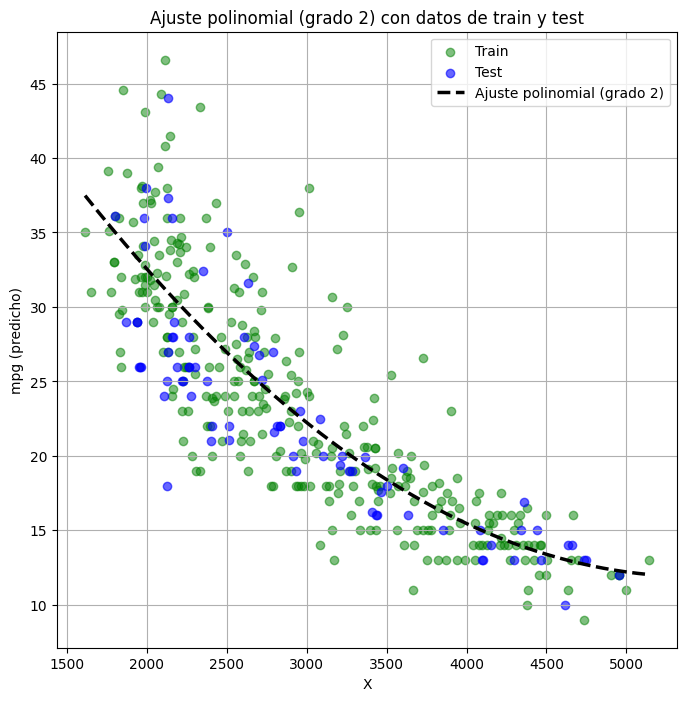

In [11]:
# Gráfico
plt.figure(figsize=(8,8))

# 1. Puntos reales
plt.scatter(X_train, y_train, color='g', alpha=0.5, label='Train')
plt.scatter(X_test, y_test, color='b', alpha=0.6, label='Test')

# 2. Curva ajustada (ordenada)
x_grid = np.linspace(X_train.min(), X_train.max(), 300).reshape(-1,1)
y_grid = plr.predict(poly.transform(x_grid))
plt.plot(x_grid, y_grid, color='black', linewidth=2.5, label='Ajuste polinomial (grado 2)', ls = "--")

# 3. Detalles
plt.xlabel(X_train.columns[0] if hasattr(X_train, "columns") else "X")
plt.ylabel("mpg (predicho)")
plt.title("Ajuste polinomial (grado 2) con datos de train y test")
plt.legend()
plt.grid(True)
plt.show()



- **Regresión lineal simple:**  
  Ajusta una **recta** para aproximar la relación entre `weight` y `mpg`.  
  Su ecuación es:

  $$
  \hat{y} = \beta_0 + \beta_1 \cdot weight
  $$

  donde:  
  - $\beta_0$ es el **intercepto** (valor de `mpg` cuando `weight = 0`).  
  - $\beta_1$ es la **pendiente** que indica cuánto cambia el consumo (`mpg`) al aumentar el peso del vehículo.

---

- **Regresión polinomial (grado 2):**  
  Agrega un término cuadrático $weight^2$ para capturar **curvaturas** en la relación.  
  Su ecuación es:

  $$
  \hat{y} = \beta_0 + \beta_1 \cdot weight + \beta_2 \cdot weight^2
  $$

  donde:  
  - $\beta_2$ controla la **curvatura** de la parábola.  
  - Si $\beta_2 > 0$, la curva se abre hacia arriba (efecto creciente).  
  - Si $\beta_2 < 0$, la curva se abre hacia abajo (efecto decreciente).  



## 4) Lineal **multivariable** (Con dos variables)


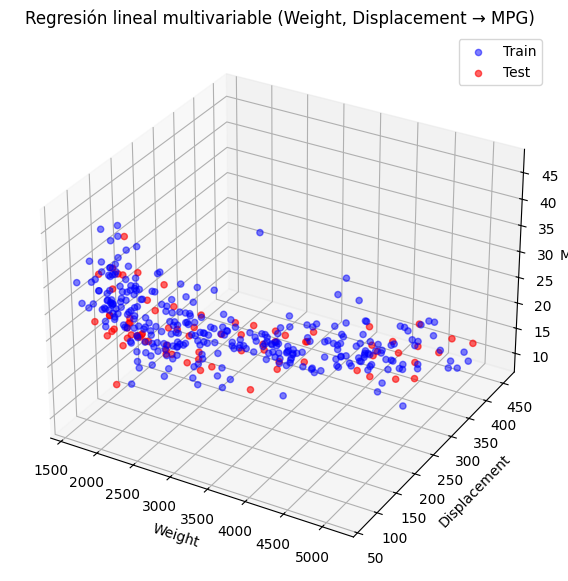

In [ ]:
# --- GRAFICAR ---
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# Puntos reales
ax.scatter(train["weight"], train["displacement"], y_train, color='blue', alpha=0.5, label='Train')
ax.scatter(test["weight"], test["displacement"], y_test, color='red', alpha=0.6, label='Test')

# Malla para el plano de regresión
# Sirve para establecer los limites del plano
w_range = np.linspace(train["weight"].min(), train["weight"].max(), 30)
d_range = np.linspace(train["displacement"].min(), train["displacement"].max(), 30)
W, D = np.meshgrid(w_range, d_range) # Crear una malla 2D

# Predicción del plano
X_grid = np.column_stack((W.ravel(), D.ravel()))

# Etiquetas y estética
ax.set_xlabel("Weight")
ax.set_ylabel("Displacement")
ax.set_zlabel("MPG")
ax.set_title("Regresión lineal multivariable (Weight, Displacement → MPG)")
ax.legend()
plt.show()

In [13]:
# Variables predictoras y dependiente
features_2d = ["weight", "displacement"]
XtrM = train[features_2d].to_numpy()
XteM = test[features_2d].to_numpy()

# Pipeline: estandarización + regresión lineal
lin_multi = Pipeline([
    ("sc", StandardScaler()),
    ("lr", LinearRegression())
])

lin_multi.fit(XtrM, y_train)
y_pred_train = lin_multi.predict(XtrM)
y_pred_test = lin_multi.predict(XteM)

# Métricas
metrics_lin_multi = {
    "MSE": mean_squared_error(y_test, y_pred_test),
    "MAE": mean_absolute_error(y_test, y_pred_test),
    "R2":  r2_score(y_test, y_pred_test)
}
print(metrics_lin_multi)


{'MSE': 18.30762724500912, 'MAE': 3.492736798949203, 'R2': 0.6413123423967872}


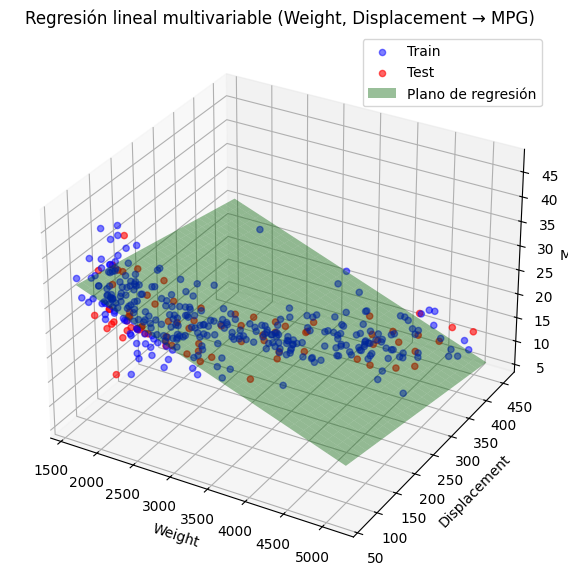

In [14]:
# --- GRAFICAR ---
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# Puntos reales
ax.scatter(train["weight"], train["displacement"], y_train, color='blue', alpha=0.5, label='Train')
ax.scatter(test["weight"], test["displacement"], y_test, color='red', alpha=0.6, label='Test')

# Malla para el plano de regresión
w_range = np.linspace(train["weight"].min(), train["weight"].max(), 30)
d_range = np.linspace(train["displacement"].min(), train["displacement"].max(), 30)
W, D = np.meshgrid(w_range, d_range)

# Predicción del plano
X_grid = np.column_stack((W.ravel(), D.ravel()))
Y_pred = lin_multi.predict(X_grid).reshape(W.shape)

# Plano de regresión
ax.plot_surface(W, D, Y_pred, color='green', alpha=0.4, label='Plano de regresión')

# Etiquetas y estética
ax.set_xlabel("Weight")
ax.set_ylabel("Displacement")
ax.set_zlabel("MPG")
ax.set_title("Regresión lineal multivariable (Weight, Displacement → MPG)")
ax.legend()
plt.show()

### ¿Qué hace el `StandardScaler`?

El **`StandardScaler`** transforma todas las variables numéricas para que estén en la **misma escala**.

Aplica la siguiente fórmula a cada valor  $x_i$:

$z_i = \frac{x_i - \mu}{\sigma}$

donde:
-  $\mu $= media de la variable en el conjunto de entrenamiento  
-  $\sigma$ = desviación estándar  

Así, cada columna transformada tendrá:
- **media = 0**  
- **desviación estándar = 1**

---

### ¿Por qué es importante?
- En modelos como **Ridge**, **Lasso** o **kNN**, las variables con valores grandes (por ejemplo `weight`) podrían dominar sobre las pequeñas (como `acceleration`).
- La estandarización garantiza que **todas las variables contribuyan por igual** al modelo.
- Además, mejora la **estabilidad numérica** y la **convergencia** del algoritmo de entrenamiento.

### ¿En que aportan los coeficientes en este caso?

Los **coeficientes del modelo** (β₀, β₁, β₂, …) representan la **orientación del plano de regresión** en el espacio de las variables.  
- En la regresión con dos predictores (`weight`, `displacement`), el modelo ajusta un plano 3D:
  
  
  $\hat{y} = \beta_0 + \beta_1 \cdot weight + \beta_2 \cdot displacement$
  
- β₀ es el intercepto (altura del plano).  
- β₁ y β₂ son las pendientes que determinan la inclinación del plano.  


## 6) **Ridge** y **Lasso** (multivariable, con cambios en los coeficientes)


Ridge: {'MSE': 18.298932269906064, 'MAE': 3.4901587681708444, 'R2': 0.6414826965454103, 'best_alpha': 1.0}


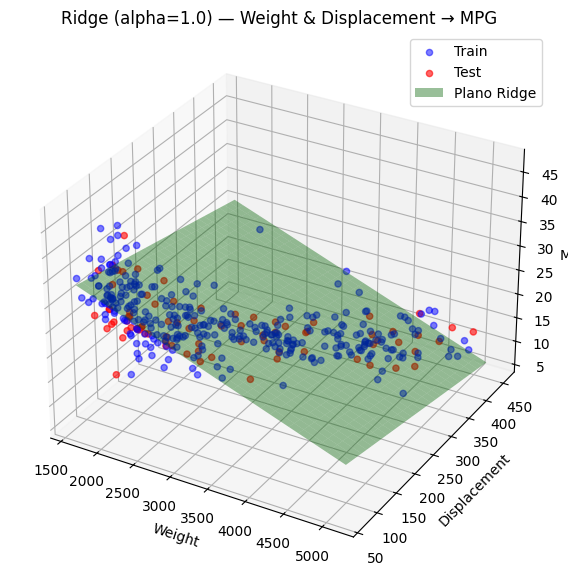

In [15]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Datos ---
XtrM = train[features_2d].to_numpy()
XteM = test[features_2d].to_numpy()

# --- Ridge con GridSearchCV ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
ridge = GridSearchCV(
    Pipeline([("sc", StandardScaler()), ("rg", Ridge(random_state=42))]),
    param_grid={"rg__alpha": [0.1, 1.0, 10.0]},
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1
)

# Kfold sirve para validar el modelo durante el entrenamiento
# y evitar overfitting al buscar el mejor hiperparámetro (alpha en este caso

# GridSearchCV realiza validación cruzada para seleccionar el mejor alpha


ridge.fit(XtrM, y_train)

# Predicciones
y_pred_train_ridge = ridge.predict(XtrM)
y_pred_test_ridge  = ridge.predict(XteM)

# Métricas
metrics_ridge = {
    "MSE": mean_squared_error(y_test, y_pred_test_ridge),
    "MAE": mean_absolute_error(y_test, y_pred_test_ridge),
    "R2":  r2_score(y_test, y_pred_test_ridge),
    "best_alpha": ridge.best_params_["rg__alpha"],
}
print("Ridge:", metrics_ridge)

# --- GRAFICAR plano de regresión + puntos ---
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# Puntos reales
ax.scatter(train["weight"], train["displacement"], y_train, color='blue', alpha=0.5, label='Train')
ax.scatter(test["weight"],  test["displacement"],  y_test,  color='red',  alpha=0.6, label='Test')

# Malla del plano
w_range = np.linspace(train["weight"].min(), train["weight"].max(), 30)
d_range = np.linspace(train["displacement"].min(), train["displacement"].max(), 30)
W, D = np.meshgrid(w_range, d_range)
X_grid = np.column_stack((W.ravel(), D.ravel()))

# Predicción del plano con el pipeline (usa el scaler interno)
Y_pred = ridge.predict(X_grid).reshape(W.shape)

# Plano
ax.plot_surface(W, D, Y_pred, color='green', alpha=0.4, label='Plano Ridge')

ax.set_xlabel("Weight")
ax.set_ylabel("Displacement")
ax.set_zlabel("MPG")
ax.set_title(f"Ridge (alpha={metrics_ridge['best_alpha']}) — Weight & Displacement → MPG")
ax.legend()
plt.show()



#### GridSearchCV (from sklearn.model_selection)

- Busca el mejor conjunto de hiperparámetros probando una grilla (o distribución) y evaluando con validación cruzada.
- Evalúa distintos alpha del paso “rg” del Pipeline: {"rg__alpha": [0.1, 1.0, 10.0]}.
- Devuelve métricas por cada combinación, el mejor score y el best_estimator_ ya reajustado (refit=True) para usar .predict.
- Evita fuga de información porque cada split ajusta el scaler y el modelo solo con su fold de entrenamiento.

#### KFold (from sklearn.model_selection)

- Define cómo partir el conjunto de entrenamiento en k “folds” para la validación cruzada (p. ej., n_splits=5).
- shuffle=True + random_state garantiza particiones aleatorias y reproducibles.
- GridSearchCV usa este esquema para evaluar cada alpha en varios folds y promediar el desempeño.

Lasso: {'MSE': 18.304709538673993, 'MAE': 3.4924054847103654, 'R2': 0.6413695068363356, 'best_alpha': 0.001}


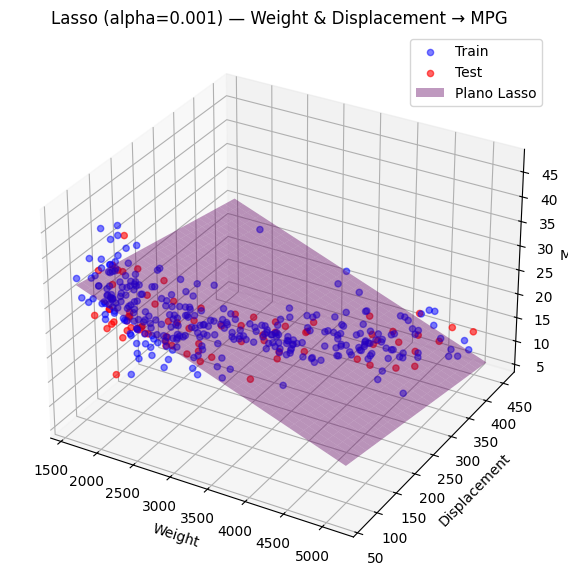

In [16]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Datos ---
XtrM = train[features_2d].to_numpy()
XteM = test[features_2d].to_numpy()

# --- Lasso con GridSearchCV ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lasso = GridSearchCV(
    Pipeline([("sc", StandardScaler()), ("ls", Lasso(random_state=42, max_iter=10000))]),
    param_grid={"ls__alpha": [0.001, 0.01, 0.1]},
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1
)
lasso.fit(XtrM, y_train)

# Predicciones
y_pred_train_lasso = lasso.predict(XtrM)
y_pred_test_lasso  = lasso.predict(XteM)

# Métricas
metrics_lasso = {
    "MSE": mean_squared_error(y_test, y_pred_test_lasso),
    "MAE": mean_absolute_error(y_test, y_pred_test_lasso),
    "R2":  r2_score(y_test, y_pred_test_lasso),
    "best_alpha": lasso.best_params_["ls__alpha"],
}
print("Lasso:", metrics_lasso)

# --- GRAFICAR plano de regresión + puntos ---
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# Puntos reales
ax.scatter(train["weight"], train["displacement"], y_train, color='blue', alpha=0.5, label='Train')
ax.scatter(test["weight"],  test["displacement"],  y_test,  color='red',  alpha=0.6, label='Test')

# Malla del plano
w_range = np.linspace(train["weight"].min(), train["weight"].max(), 30)
d_range = np.linspace(train["displacement"].min(), train["displacement"].max(), 30)
W, D = np.meshgrid(w_range, d_range)
X_grid = np.column_stack((W.ravel(), D.ravel()))

# Predicción del plano con el pipeline (usa el scaler interno)
Y_pred = lasso.predict(X_grid).reshape(W.shape)

# Plano
ax.plot_surface(W, D, Y_pred, color='purple', alpha=0.4, label='Plano Lasso')

ax.set_xlabel("Weight")
ax.set_ylabel("Displacement")
ax.set_zlabel("MPG")
ax.set_title(f"Lasso (alpha={metrics_lasso['best_alpha']}) — Weight & Displacement → MPG")
ax.legend()
plt.show()


### Diferencia entre Regresión Lineal, Ridge y Lasso

- **Regresión lineal múltiple:**  
  Busca los coeficientes que minimizan el error cuadrático medio (MSE).  
  No aplica penalización, por lo que los coeficientes pueden crecer mucho si las variables están correlacionadas (riesgo de sobreajuste).

- **Ridge (regularización L2):**  
  Agrega una penalización cuadrática $\alpha \sum \beta_j^2$.  
  Reduce la magnitud de los coeficientes, evitando que se inflen demasiado.  
  No elimina variables, pero **suaviza** el modelo y controla la varianza.

- **Lasso (regularización L1):**  
  Agrega una penalización absoluta $\alpha \sum |\beta_j|$.  
  Puede llevar algunos coeficientes exactamente a **0**, eliminando variables irrelevantes.  
  Útil para **selección de características** y obtener modelos más simples.

En resumen:  
> - **Lineal:** sin penalización (puede sobreajustar).  
> - **Ridge:** encoge los coeficientes (suaviza).  
> - **Lasso:** encoge y puede eliminar variables (simplifica).


Los **coeficientes del modelo** (β₀, β₁, β₂, …) representan la **orientación del plano de regresión** en el espacio de las variables.  
- En la regresión con dos predictores (`weight`, `displacement`), el modelo ajusta un plano 3D:
  
  
  $\hat{y} = \beta_0 + \beta_1 \cdot weight + \beta_2 \cdot displacement$
  
- β₀ es el intercepto (altura del plano).  
- β₁ y β₂ son las pendientes que determinan la inclinación del plano.  
- En **Ridge**, el plano es más “suave” (coeficientes más pequeños).  
- En **Lasso**, alguna pendiente puede ser 0 (una variable deja de influir).


### Ejemplo

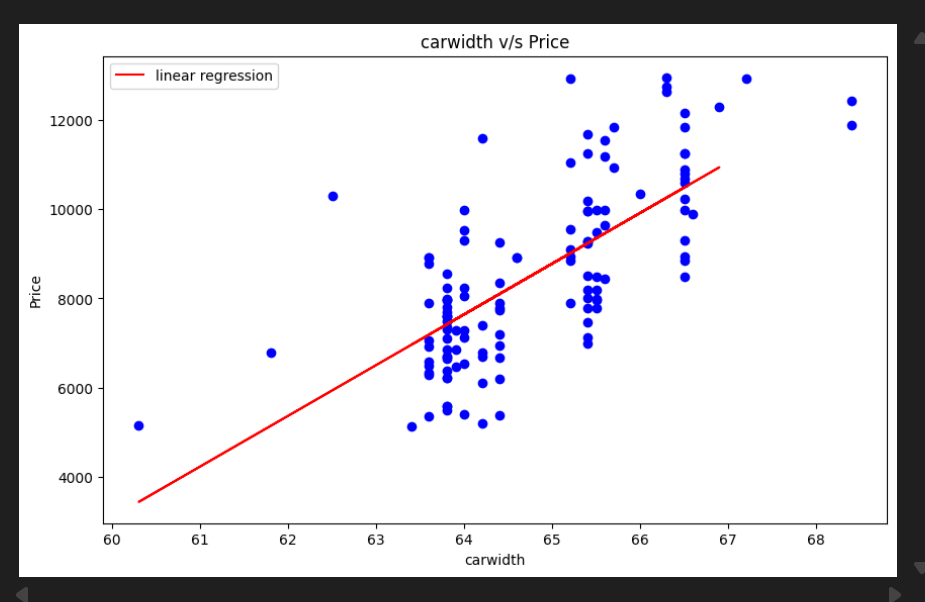

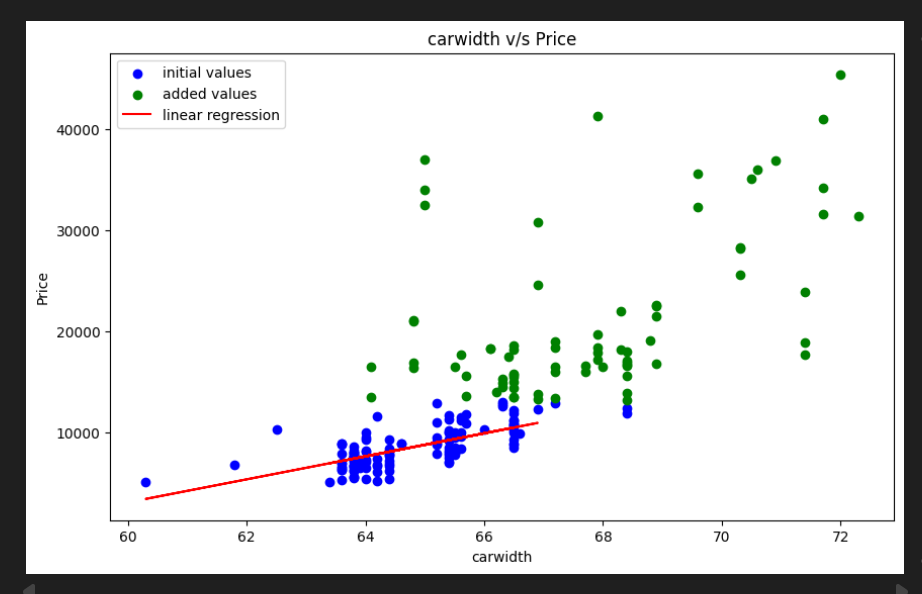

#### Regularización con Ridge y Lasso al agregar nuevos datos

En la primera figura (modelo inicial, puntos azules), la regresión lineal se ajusta correctamente a los datos conocidos:  
la línea roja representa la tendencia aprendida por el modelo.

Sin embargo, al agregar **nuevos valores (puntos verdes)**, la recta deja de representar bien la relación entre `carwidth` y `Price`.  
Esto ocurre porque el modelo fue **entrenado solo con los datos iniciales**, y sus coeficientes se ajustaron demasiado a ese conjunto.  
➡️ Este fenómeno se conoce como **sobreajuste** (*overfitting*): el modelo aprende patrones específicos del conjunto original, y pierde capacidad de generalización.

---

#### Cómo ayudan Ridge y Lasso

Ambos modelos aplican **regularización**, agregando una penalización sobre los coeficientes para evitar que crezcan demasiado:

- **Ridge (L2):**
  $$
  J(\beta) = \frac{1}{n}\sum (y_i - \hat{y}_i)^2 + \alpha \sum \beta_j^2
  $$
  🔹 Reduce la magnitud de todos los coeficientes, haciendo que el modelo sea **más estable y menos sensible** a los cambios en los datos.  
  🔹 Al agregar nuevos puntos (verdes), la pendiente del modelo no cambia bruscamente.

- **Lasso (L1):**
  $$
  J(\beta) = \frac{1}{n}\sum (y_i - \hat{y}_i)^2 + \alpha \sum |\beta_j|
  $$
  🔹 Además de reducir la magnitud, puede llevar algunos coeficientes exactamente a **0**, eliminando variables irrelevantes.  
  🔹 Esto simplifica el modelo y evita depender demasiado de una sola característica (como `carwidth`).

---

#### En resumen

| Modelo | Comportamiento al agregar nuevos datos | Efecto de la regularización |
|:--------|:---------------------------------------|:-----------------------------|
| **Lineal simple** | La pendiente cambia con facilidad, el modelo se desestabiliza. | ❌ No controla la magnitud de los coeficientes. |
| **Ridge (L2)** | La recta se mantiene más estable ante nuevos datos. | ✅ Encoge los coeficientes, reduce varianza. |
| **Lasso (L1)** | El modelo se ajusta a los datos relevantes, ignorando ruido. | ✅ Elimina coeficientes irrelevantes (sparse model). |

---

En este caso, **Ridge** o **Lasso** harían que la línea roja se mantenga más estable al incorporar los nuevos puntos verdes, evitando que el modelo “olvide” la tendencia general aprendida con los datos iniciales.


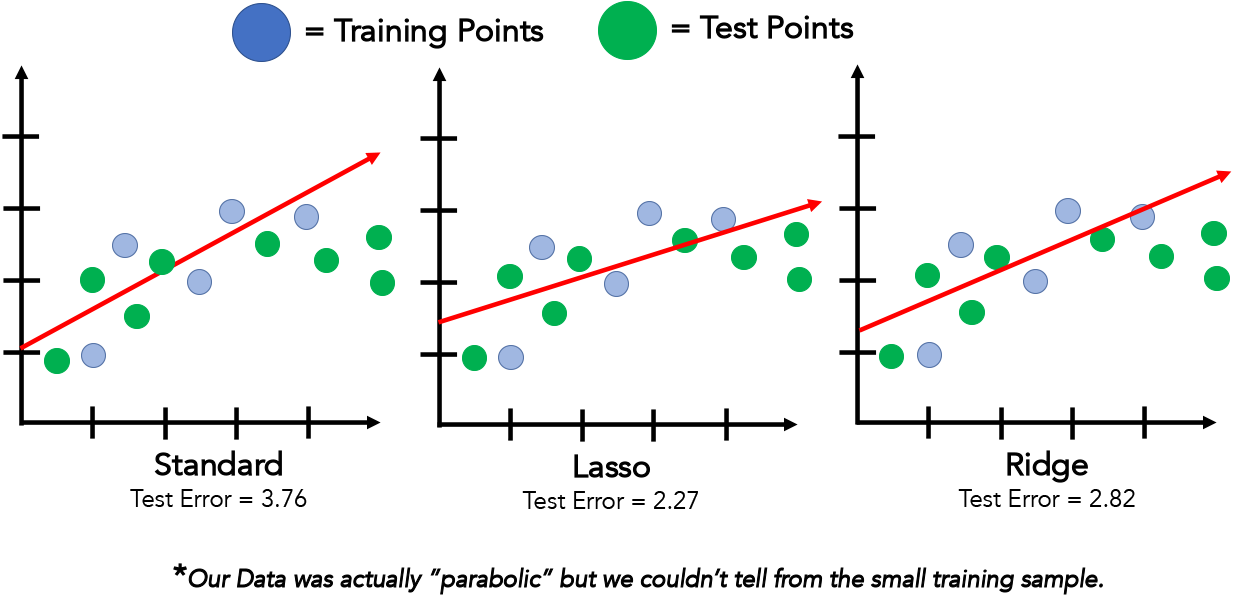


## 7) Coeficientes multivariable
Coeficientes estandarizados para multivariable, Ridge y Lasso.

In [17]:
feat_names = ["weight", "displacement"]  # mismas columnas en los tres modelos

# lin_multi con las mismas dos variables
Xtr2 = train[feat_names].to_numpy()
lin_multi_2 = Pipeline([("sc", StandardScaler()), ("lr", LinearRegression())]).fit(Xtr2, y_train)

def coef_series(model, step, names):
    est = model.best_estimator_.named_steps[step] if hasattr(model, "best_estimator_") else model.named_steps[step]
    return pd.Series(est.coef_, index=names)

coef_df = pd.DataFrame({
    "Linear": lin_multi_2.named_steps["lr"].coef_,
    "Ridge":  coef_series(ridge, "rg", feat_names),
    "Lasso":  coef_series(lasso, "ls", feat_names),
}, index=feat_names).sort_values("Linear", key=lambda s: s.abs(), ascending=False)

coef_df


,Linear,Ridge,Lasso
weight,-4.705697,-4.644844,-4.707708
displacement,-2.083010,-2.132628,-2.080145



## 8) Comparativa final


In [18]:

import pandas as pd
results = pd.DataFrame([
    {"Modelo":"Baseline", **baseline},
    {"Modelo":f"Lineal simple [{best_feat}]", **metrics_lin_simple},
    {"Modelo":"Lineal multivariable", **metrics_lin_multi},
    {"Modelo":f"Polinomial grado 2 [{best_feat}]", **metrics_poly},
    {"Modelo":f"Ridge (alpha={metrics_ridge['best_alpha']})", **{k:v for k,v in metrics_ridge.items() if k in ["MSE","MAE","R2"]}},
    {"Modelo":f"Lasso (alpha={metrics_lasso['best_alpha']})", **{k:v for k,v in metrics_lasso.items() if k in ["MSE","MAE","R2"]}},
]).sort_values("MSE")
results.reset_index(drop=True)


,Modelo,MSE,MAE,R2
0,Polinomial grado 2 [weight],16.689074,3.138326,0.673023
1,Lineal simple [weight],17.693388,3.464121,0.653347
2,Ridge (alpha=1.0),18.298932,3.490159,0.641483
3,Lasso (alpha=0.001),18.304710,3.492405,0.641370
4,Lineal multivariable,18.307627,3.492737,0.641312
5,Baseline,51.620292,5.880956,-0.011358


## 9) Drive

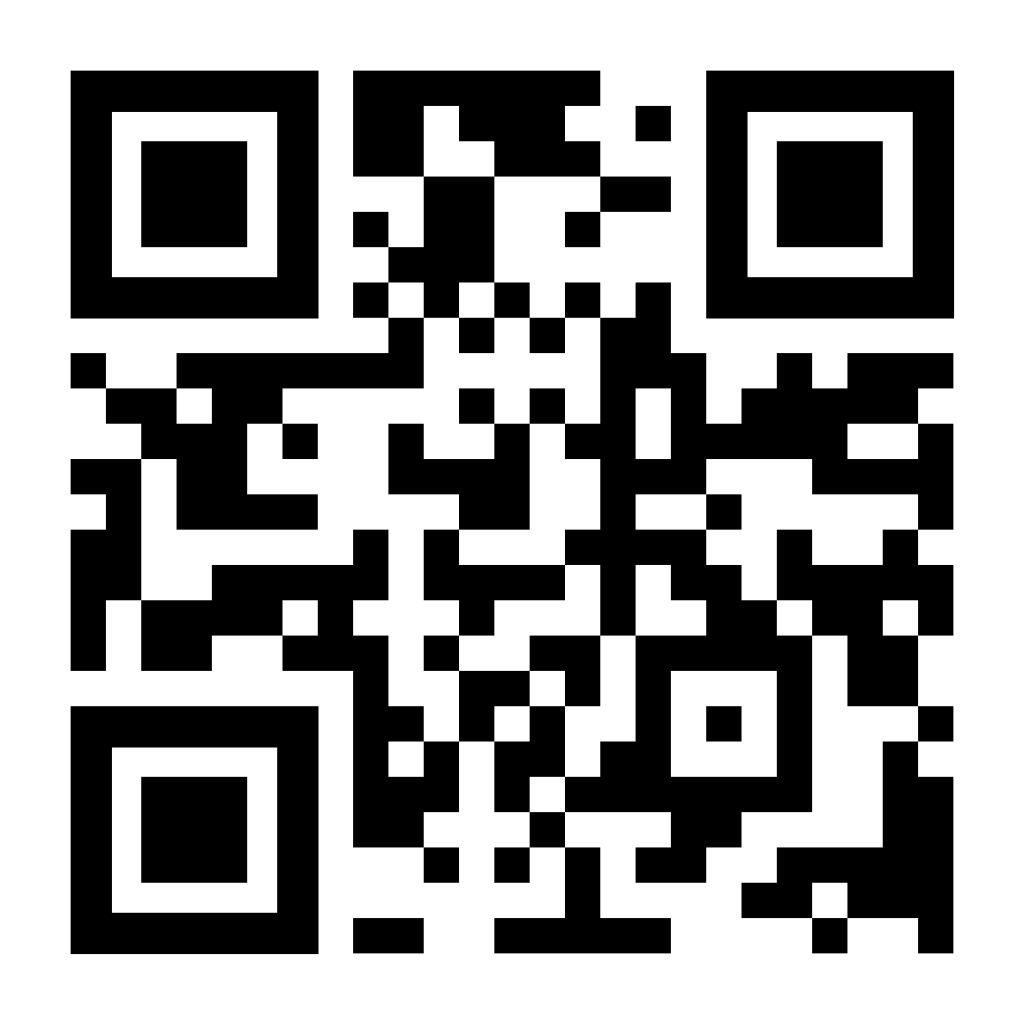

[Drive del año pasado](https://uccl0.sharepoint.com/sites/uc365_CentraldeApuntesLICD/Shared%20Documents/Forms/AllItems.aspx?id=%2Fsites%2Fuc365%5FCentraldeApuntesLICD%2FShared%20Documents%2FCentral%20de%20Apuntes%20LICD%2F02%20SEMESTRE%2FIntroducci%C3%B3n%20a%20la%20Ciencia%20de%20Datos%2F2024%2D2&viewid=13b63e0c%2D1e27%2D4076%2D9bf1%2D18bb9d31beca)